# WAHIS Data Exploration

This notebook explores the WAHIS dataset to understand outbreak patterns by country, disease, species, and year.

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.style.use("ggplot")
pd.set_option("display.max_columns", None)

DATA_FILE = Path("data/01_raw/wahis_2025-09-18.csv")
if not DATA_FILE.exists():
    DATA_FILE = Path("../data/01_raw/wahis_2025-09-18.csv")

RESULTS_DIR = Path("results")
if not RESULTS_DIR.exists():
    RESULTS_DIR = Path("../results")

RESULTS_DIR.mkdir(parents=True, exist_ok=True)

DATA_FILE, RESULTS_DIR


(WindowsPath('../data/01_raw/wahis_2025-09-18.csv'), WindowsPath('../results'))

In [2]:
df = pd.read_csv(DATA_FILE)
rows, cols = df.shape
print(f"Rows: {rows:,}")
print(f"Columns: {cols}")
df.head()


Rows: 569,062
Columns: 19


,Year,Semester,World region,Country,Administrative Division,Disease,Serotype/Subtype/Genotype,Animal Category,Species,Outbreak ID,Event ID,New outbreaks,Susceptible,Measuring units,Cases,Killed and disposed of,Slaughtered,Deaths,Vaccinated
0,2005,Jul-Dec 2005,Africa,Algeria,Alger,Varroa spp. (Inf. of honey bees with) (Varroosis),NaN,Both animal categories,NaN,-,-,3,-,-,-,-,-,-,-
1,2005,Jul-Dec 2005,Africa,Algeria,Alger,Varroa spp. (Inf. of honey bees with) (Varroosis),NaN,Domestic,Bees,-,-,-,46,Hives,3,3,0,-,-
2,2005,Jul-Dec 2005,Africa,Algeria,Algeria,Bovine tuberculosis (-2018),NaN,Both animal categories,NaN,-,-,92,-,-,-,-,-,-,-
3,2005,Jul-Dec 2005,Africa,Algeria,Algeria,Bovine tuberculosis (-2018),NaN,Domestic,Cattle,-,-,-,1487,Animal,193,0,193,0,-
4,2005,Jul-Dec 2005,Africa,Algeria,Algeria,Brucella abortus (Inf. with),NaN,Both animal categories,NaN,-,-,271,-,-,-,-,-,-,-


In [3]:
df_clean = df.replace("-", pd.NA).copy()

numeric_columns = [
    "New outbreaks",
    "Susceptible",
    "Cases",
    "Deaths",
    "Killed and disposed of",
    "Slaughtered",
    "Vaccinated",
]

for col in numeric_columns:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

df_clean["new_outbreaks"] = df_clean["New outbreaks"].fillna(0).astype(int)
df_clean["Year"] = pd.to_numeric(df_clean["Year"], errors="coerce").astype("Int64")
df_clean["Species"] = df_clean["Species"].fillna("Unknown")
df_clean["Country"] = df_clean["Country"].fillna("Unknown")
df_clean["Disease"] = df_clean["Disease"].fillna("Unknown")

df_clean[["Year", "Country", "Disease", "Species", "new_outbreaks"]].head()


,Year,Country,Disease,Species,new_outbreaks
0,2005,Algeria,Varroa spp. (Inf. of honey bees with) (Varroosis),Unknown,3
1,2005,Algeria,Varroa spp. (Inf. of honey bees with) (Varroosis),Bees,0
2,2005,Algeria,Bovine tuberculosis (-2018),Unknown,92
3,2005,Algeria,Bovine tuberculosis (-2018),Cattle,0
4,2005,Algeria,Brucella abortus (Inf. with),Unknown,271


In [4]:
summary_data = {
    "rows": f"{len(df_clean):,}",
    "countries": df_clean["Country"].nunique(),
    "diseases": df_clean["Disease"].nunique(),
    "species": df_clean["Species"].nunique(),
}

year_values = df_clean["Year"].dropna().astype(int)
if not year_values.empty:
    summary_data["years_covered"] = f"{year_values.min()} - {year_values.max()}"

pd.DataFrame.from_dict(summary_data, orient="index", columns=["value"])


,value
rows,"569,062"
countries,201
diseases,177
species,1140
years_covered,2005 - 2025


In [5]:
def plot_and_save(series, title, xlabel, ylabel, filename):
    series = series.sort_values()
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(series.index, series.values, color="#1f77b4")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))
    ax.invert_yaxis()
    plt.tight_layout()
    output_path = RESULTS_DIR / filename
    fig.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    return output_path


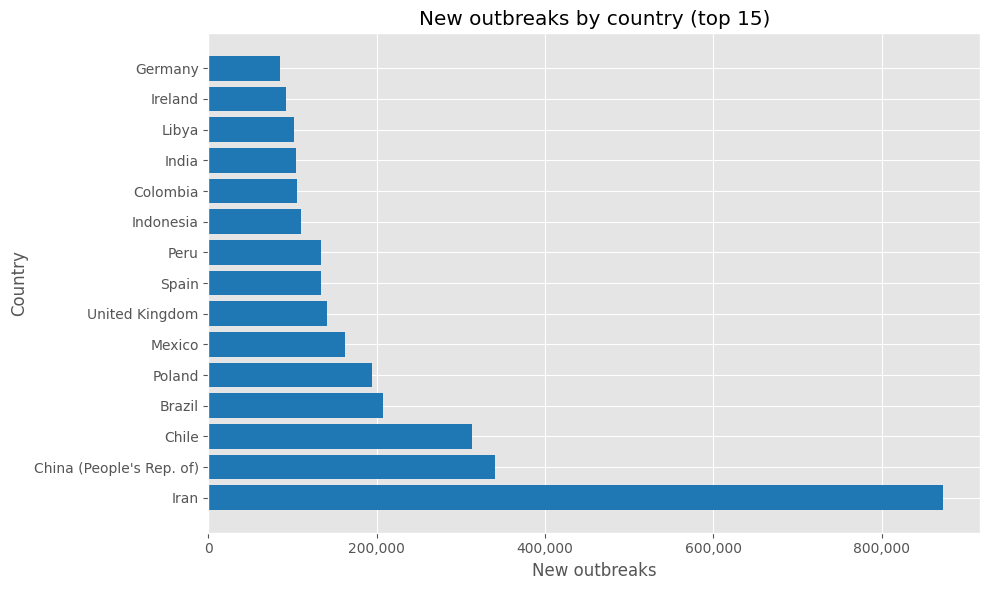

,Country,new_outbreaks
0,Iran,873265
1,China (People's Rep. of),340857
2,Chile,313187
3,Brazil,207734
4,Poland,193971
5,Mexico,162185
6,United Kingdom,140652
7,Spain,134303
8,Peru,133588
9,Indonesia,110029


In [6]:
country_outbreaks = (
    df_clean.groupby("Country")["new_outbreaks"]
    .sum()
    .sort_values(ascending=False)
    .head(15)
)

country_fig = plot_and_save(
    country_outbreaks,
    "New outbreaks by country (top 15)",
    "New outbreaks",
    "Country",
    "outbreaks_by_country.png",
)
country_outbreaks.sort_values(ascending=False).reset_index(name="new_outbreaks")


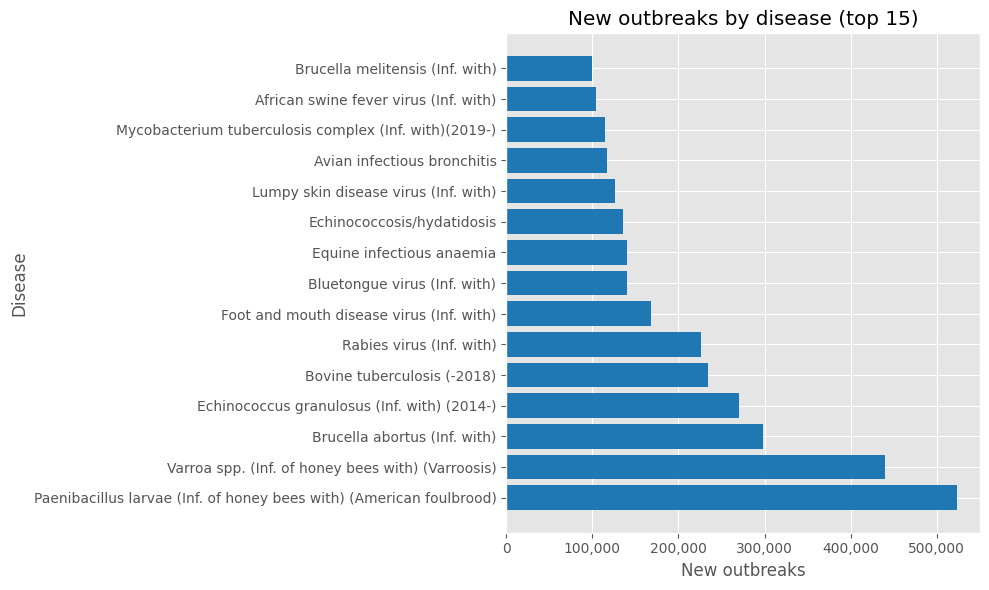

,Disease,new_outbreaks
0,Paenibacillus larvae (Inf. of honey bees with)...,523987
1,Varroa spp. (Inf. of honey bees with) (Varroosis),439529
2,Brucella abortus (Inf. with),298770
3,Echinococcus granulosus (Inf. with) (2014-),270817
4,Bovine tuberculosis (-2018),234872
5,Rabies virus (Inf. with),226144
6,Foot and mouth disease virus (Inf. with),168762
7,Bluetongue virus (Inf. with),139953
8,Equine infectious anaemia,139878
9,Echinococcosis/hydatidosis,135776


In [7]:
disease_outbreaks = (
    df_clean.groupby("Disease")["new_outbreaks"]
    .sum()
    .sort_values(ascending=False)
    .head(15)
)

disease_fig = plot_and_save(
    disease_outbreaks,
    "New outbreaks by disease (top 15)",
    "New outbreaks",
    "Disease",
    "outbreaks_by_disease.png",
)
disease_outbreaks.sort_values(ascending=False).reset_index(name="new_outbreaks")


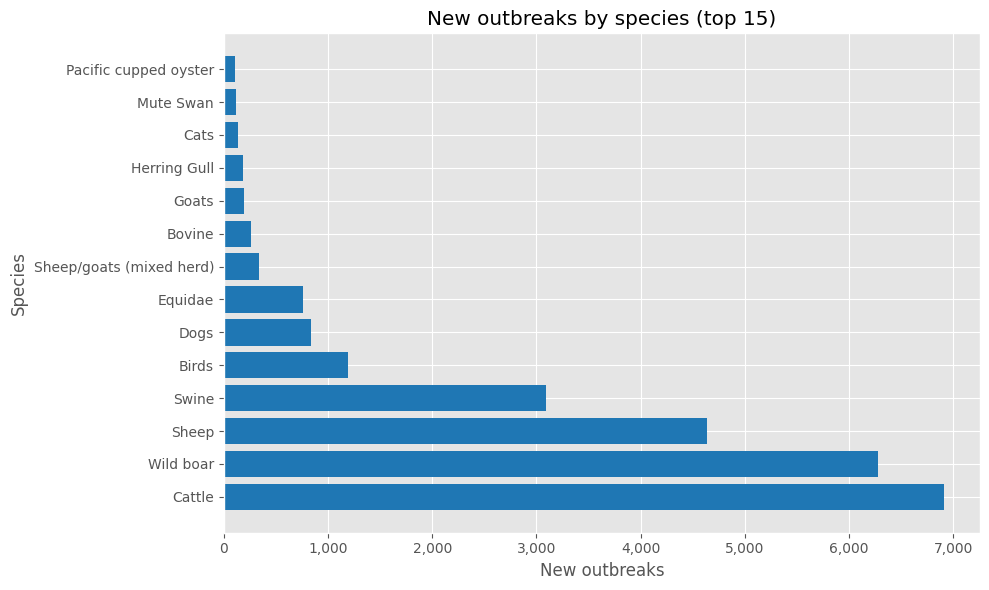

,Species,new_outbreaks
0,Unknown,4738367
1,Cattle,6911
2,Wild boar,6275
3,Sheep,4640
4,Swine,3095
5,Birds,1189
6,Dogs,837
7,Equidae,757
8,Sheep/goats (mixed herd),338
9,Bovine,258


In [14]:
species_outbreaks = (
    df_clean.groupby("Species")["new_outbreaks"]
    .sum()
    .sort_values(ascending=False)
    .head(15)
)
species_plot = species_outbreaks[species_outbreaks.index != "Unknown"]

species_fig = plot_and_save(
    species_plot,
    "New outbreaks by species (top 15)",
    "New outbreaks",
    "Species",
    "outbreaks_by_species.png",
)
species_outbreaks.sort_values(ascending=False).reset_index(name="new_outbreaks")


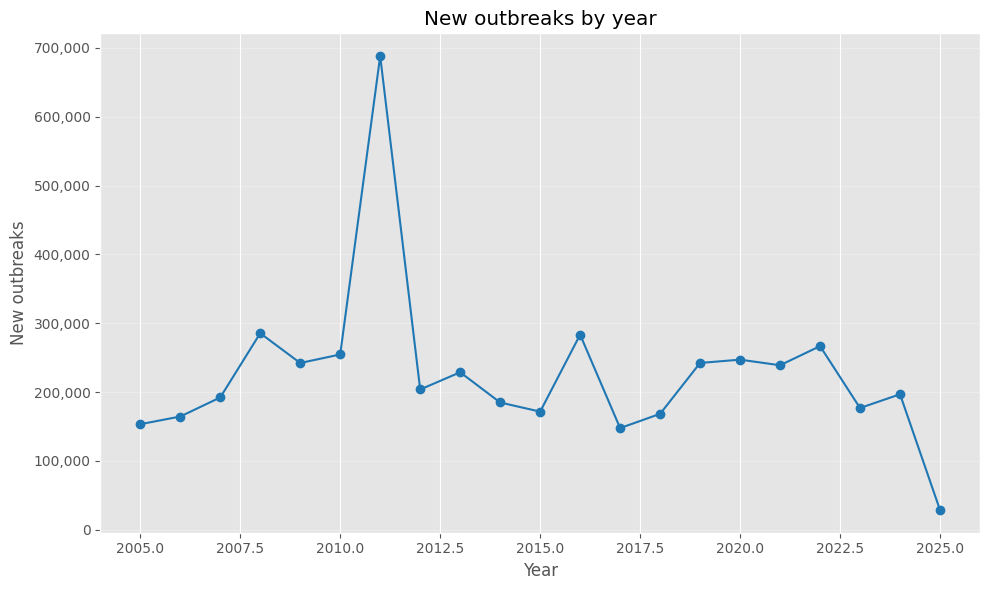

,Year,new_outbreaks
0,2005,153253
1,2006,164407
2,2007,192119
3,2008,285454
4,2009,242182
5,2010,254572
6,2011,688216
7,2012,203699
8,2013,228708
9,2014,184815


In [15]:
annual_outbreaks = (
    df_clean.dropna(subset=["Year"])
    .groupby("Year")["new_outbreaks"]
    .sum()
    .sort_index()
)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(annual_outbreaks.index.astype(int), annual_outbreaks.values, marker="o", color="#1f77b4")
ax.set_title("New outbreaks by year")
ax.set_xlabel("Year")
ax.set_ylabel("New outbreaks")
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()

year_fig = RESULTS_DIR / "outbreaks_by_year.png"
fig.savefig(year_fig, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

annual_outbreaks.reset_index(name="new_outbreaks")


In [16]:
figure_paths = {
    "by_country": str(country_fig),
    "by_disease": str(disease_fig),
    "by_species": str(species_fig),
    "by_year": str(year_fig),
}
figure_paths


{'by_country': '..\\results\\outbreaks_by_country.png',
 'by_disease': '..\\results\\outbreaks_by_disease.png',
 'by_species': '..\\results\\outbreaks_by_species.png',
 'by_year': '..\\results\\outbreaks_by_year.png'}

Figures are saved to the `results/` directory for use in the written summary.